<a href="https://colab.research.google.com/github/sayanbanerjee32/TASI_ERAv2_S22/blob/main/VAE_for_MNSIT_image_and_label_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
! pip install pytorch-lightning
# ! pip install pytorch-lightning-bolts
! pip install git+https://github.com/PytorchLightning/lightning-bolts.git@master --upgrade

In [ ]:
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

/usr/local/lib/python3.10/dist-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.10/dist-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:93: UnderReviewWarning: The featu

In [ ]:
class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32, num_classes=10):
        super().__init__()

        self.save_hyperparameters()

        # Initial conv layer to adjust input channels
        # self.initial_conv = nn.Conv2d(1 + num_classes, 3, kernel_size=3, stride=1, padding=1)
        self.initial_conv_block = nn.Sequential(
                    nn.Conv2d(1 + num_classes, 3, kernel_size=(1, 1), padding=0, bias=False),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(3),
        )

        # encoder, decoder
        self.encoder = resnet18_encoder(first_conv=False, maxpool1=False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim + num_classes,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )
        # Final conv layer to adjust output channels to 1 and decrease from 32 x 32 to 28x28
        # self.final_conv = nn.Conv2d(3, 1, kernel_size=5, stride=1, padding=0)
        self.final_conv_block = nn.Sequential(
                    nn.Conv2d(3, 1, kernel_size=(1, 1), padding=0, bias=False),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(1),
                    nn.Conv2d(1, 1, kernel_size=(3, 3), padding=0, bias=False),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(1),
                    nn.Conv2d(1, 1, kernel_size=(3, 3), padding=0, bias=False),
        )



        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)
        kl = (log_qzx - log_pz).sum(-1)
        return kl

    def forward(self, x, labels):
        # One-hot encode labels
        labels_onehot = F.one_hot(labels, num_classes=self.hparams.num_classes).float()
        labels_onehot = labels_onehot.unsqueeze(2).unsqueeze(3).expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat((x, labels_onehot), dim=1)  # batch_size x (embed_dim + num channels) x img_size x img_size
        x = self.initial_conv_block(x) # convert to 3 channels as resnet encoder supports 3 channels
        x_encoded = self.encoder(x)#.reshape(x.size(0), -1)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # # Ensure the label embedding is concatenated correctly
        # Concatenate latent space with label embeddings
        z = torch.cat((z, labels_onehot[:, :, 0, 0]), dim=1)  # Use label embedding in latent space
        x_hat = self.decoder(z)
        x_hat = self.final_conv_block(x_hat) # convert to 1 channel as resnet decoder supports 3 channels

        return x_hat, mu, log_var

    def training_step(self, batch, batch_idx):
        x, labels = batch
        x_hat, mu, log_var = self(x, labels)

        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)
        kl = self.kl_divergence(z, mu, std)
        elbo = (kl - recon_loss).mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean()
        })

        return elbo


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from pl_bolts.datamodules import MNISTDataModule
mnist = MNISTDataModule('.',batch_size = 512)
mnist.prepare_data()
mnist.setup()

In [ ]:
pl.seed_everything(1234)
epochs = 50
vae = VAE()
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=epochs, enable_progress_bar=True)
trainer.fit(vae, mnist)

NameError: name 'pl' is not defined

## Plot an image

In [ ]:
test = mnist.val_dataloader()
x, y = next(iter(test))
x.shape, y.shape

(torch.Size([512, 1, 28, 28]), torch.Size([512]))

In [ ]:
num_preds = 25
y_t = y[0:num_preds]
print(y_t)
# Generate a random permutation of indices
indices = torch.randperm(y.numel())
shuffled_y = y[indices][0:num_preds]
shuffled_y

tensor([2, 8, 7, 9, 2, 1, 5, 2, 8, 6, 6, 5, 7, 3, 4, 6, 2, 0, 8, 4, 9, 7, 6, 2,
        3])


tensor([9, 7, 8, 2, 2, 7, 5, 9, 1, 2, 0, 9, 6, 6, 6, 1, 5, 0, 7, 3, 2, 3, 7, 4,
        6])

In [ ]:
with torch.no_grad():
    pred , mu, log_var = vae(x[0:num_preds].to(vae.device), shuffled_y.to(vae.device))

print('mu:', mu.shape)
print('log_var:', log_var.shape)

# SAMPLE Z from Q(Z|x)
std = torch.exp(log_var / 2)
q = torch.distributions.Normal(mu, std)
z = q.rsample()

print('z shape:', z.shape)
print('pred size:', pred.size())

mu: torch.Size([25, 256])
log_var: torch.Size([25, 256])
z shape: torch.Size([25, 256])
pred size: torch.Size([25, 1, 28, 28])


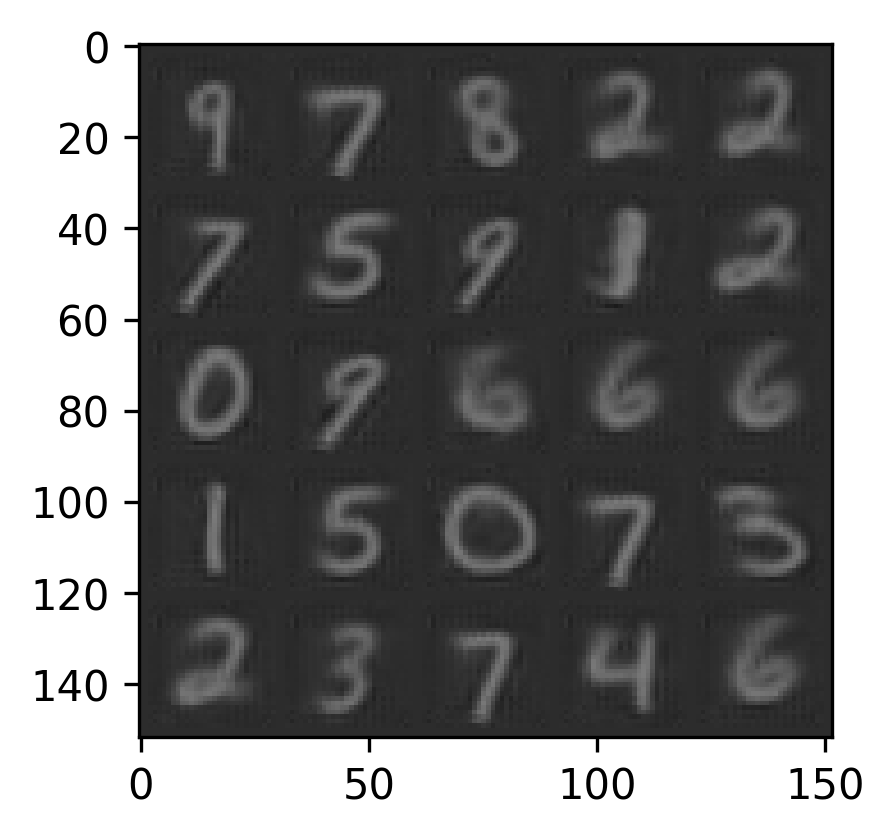

In [ ]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
from pl_bolts.transforms.dataset_normalizations import emnist_normalization
figure(figsize=(8, 3), dpi=300)

pred = pred.cpu()
# UNDO DATA NORMALIZATION
normalize = emnist_normalization('mnist')
mean, std = np.array(normalize.mean), np.array(normalize.std)
img = make_grid(pred,nrow = 5).permute(1, 2, 0).numpy() * std + mean

# PLOT IMAGES
imshow(img);

## Labeled images

In [ ]:
import matplotlib.pyplot as plt
def plot_image(images, target_labels, pred_labels = None, rows = 5, cols = 5,
               img_size=(5,5), font_size = 7):
    figure = plt.figure(figsize=img_size)
    for index in range(cols * rows):
        plt.subplot(rows, cols, index+1)
        if pred_labels is not None:
            plt.title(f'image: {target_labels[index]}\nlabel: {pred_labels[index]}',
                  fontsize = font_size)
        else:
            plt.title(f'image: {target_labels[index]}', fontsize = font_size)
        plt.axis('off')
        plt.imshow(images[index])
    figure.tight_layout()
    plt.show()

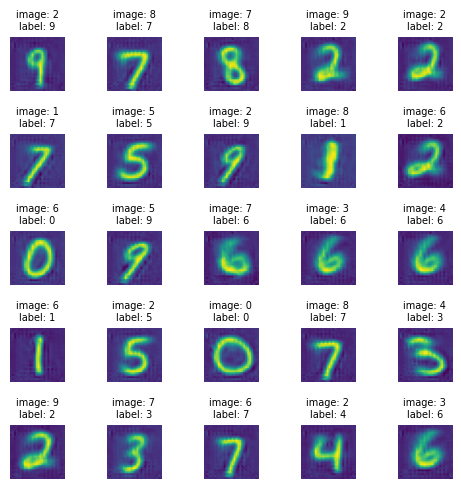

In [ ]:
imgs = pred.permute(0, 2, 3, 1).numpy() * std + mean
plot_image(imgs, target_labels = y_t, pred_labels = shuffled_y)